<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
# Desafio 3

Esta primera sección del código se encarga de la preparación y preprocesamiento de los datos. Comenzamos importando las librerías necesarias (pandas, tensorflow, matplotlib) y luego descargamos el dataset. Una vez obtenidos los datos, cargamos el archivo de letras de Eminem en un DataFrame y concatenamos todas las líneas en un corpus único, aplicando conversión a minúsculas para normalizar el texto. El paso más crítico es el filtrado de caracteres: se toman únicamente las 26 letras del alfabeto inglés más el espacio, eliminando números, signos de puntuación y caracteres especiales que podrían introducir ruido en el entrenamiento. Finalmente, se implementa la tokenización a nivel de caracteres creando dos diccionarios bidireccionales que mapean caracteres a índices numéricos y viceversa, resultando en un vocabulario controlado de 27 caracteres únicos que facilita el aprendizaje del modelo.

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import platform
import string


if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            os.system('curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip')
        else:
            os.system('wget -O songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip')
    os.system('unzip -q songs_dataset.zip')
else:
    print("El dataset ya se encuentra descargado")


with open('songs_dataset/eminem.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

df = pd.DataFrame({'verse': [line.strip() for line in lines if line.strip()]})

text_corpus = ' '.join(df['verse'].tolist())
text_corpus = text_corpus.lower()

allowed_chars = set(string.ascii_lowercase + ' ')
text_corpus = ''.join([c for c in text_corpus if c in allowed_chars])

text_corpus = ' '.join(text_corpus.split())

chars = sorted(list(set(text_corpus)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)



El dataset ya se encuentra descargado


Esta segunda sección implementa la creación del dataset de entrenamiento y las arquitecturas de los modelos. Primero se divide el texto en secuencias de 80 caracteres, donde cada secuencia sirve como input y el target es la misma secuencia desplazada un carácter hacia adelante (técnica de predicción del siguiente carácter). Se aplica shuffling con un buffer de 10000 elementos y se organiza en batches de 32 secuencias, dividiendo finalmente el dataset en 80% para entrenamiento y 20% para validación. Las arquitecturas de los modelos están diseñadas con regularización intensiva: ambos modelos (SimpleRNN y LSTM) tienen 128 unidades recurrentes (neuronas en la capa RNN/LSTM), múltiples capas de dropout (0.4, 0.6, 0.4) y una capa densa intermedia para prevenir sobreajuste. Las funciones de generación implementan tres estrategias diferentes: búsqueda codiciosa que siempre elige el carácter más probable, muestreo estocástico que introduce aleatoriedad controlada por temperatura, y beam search que mantiene múltiples hipótesis simultáneamente.

In [12]:
seq_length = 80
examples_per_epoch = len(text_corpus) // seq_length

char_dataset = tf.data.Dataset.from_tensor_slices([char_to_idx[c] for c in text_corpus])
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

buffer_size = 10000
batch_size = 32
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

train_size = int(0.8 * len(list(dataset)))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

class PerplexityCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss:
            perplexity = np.exp(val_loss)
            print(f'Época {epoch+1} - Perplejidad: {perplexity:.2f}')

def create_simple_rnn_final(vocab_size, embedding_dim=128, rnn_units=128):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim),
        layers.Dropout(0.4),
        layers.SimpleRNN(rnn_units, return_sequences=True, recurrent_dropout=0.3),
        layers.Dropout(0.6),
        layers.Dense(rnn_units//2, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(vocab_size)
    ])
    return model

def create_lstm_final(vocab_size, embedding_dim=128, rnn_units=128):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim),
        layers.Dropout(0.4),
        layers.LSTM(rnn_units, return_sequences=True, recurrent_dropout=0.3),
        layers.Dropout(0.6),
        layers.Dense(rnn_units//2, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(vocab_size)
    ])
    return model

def greedy_search(model, start_string, num_generate=200):
    input_eval = [char_to_idx[s] for s in start_string if s in char_to_idx]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []
    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predicted_id = tf.argmax(predictions[-1]).numpy()

        new_char = tf.expand_dims([predicted_id], 0)
        input_eval = tf.concat([input_eval, new_char], axis=1)

        if input_eval.shape[1] > seq_length:
            input_eval = input_eval[:, -seq_length:]

        text_generated.append(idx_to_char[predicted_id])

    return start_string + ''.join(text_generated)

def stochastic_sampling(model, start_string, temperature=1.0, num_generate=200):
    input_eval = [char_to_idx[s] for s in start_string if s in char_to_idx]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []
    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions[-1:], num_samples=1)[-1,0].numpy()

        new_char = tf.expand_dims([predicted_id], 0)
        input_eval = tf.concat([input_eval, new_char], axis=1)

        if input_eval.shape[1] > seq_length:
            input_eval = input_eval[:, -seq_length:]

        text_generated.append(idx_to_char[predicted_id])

    return start_string + ''.join(text_generated)

def beam_search(model, start_string, beam_width=3, num_generate=100):
    input_eval = [char_to_idx[s] for s in start_string if s in char_to_idx]
    beams = [(input_eval, 0.0)]

    for _ in range(num_generate):
        candidates = []

        for seq, score in beams:
            input_seq = seq[-seq_length:] if len(seq) > seq_length else seq
            input_tensor = tf.expand_dims(input_seq, 0)
            predictions = model(input_tensor)
            predictions = tf.nn.log_softmax(predictions[0, -1])

            top_k = tf.nn.top_k(predictions, beam_width)

            for i in range(beam_width):
                token_id = top_k.indices[i].numpy()
                token_score = top_k.values[i].numpy()
                new_seq = seq + [token_id]
                new_score = score + token_score
                candidates.append((new_seq, new_score))

        candidates.sort(key=lambda x: x[1], reverse=True)
        beams = candidates[:beam_width]

    best_seq = beams[0][0]
    return ''.join([idx_to_char[idx] for idx in best_seq])

modelos = {
    'SimpleRNN': create_simple_rnn_final(vocab_size),
    'LSTM': create_lstm_final(vocab_size)
}



Esta sección muestra los resultados del entrenamiento con parámetros idénticos para ambos modelos. El loop de entrenamiento compila cada modelo con RMSprop (learning rate 0.0005), entropía cruzada sparse como función de pérdida, e incluye accuracy como métrica adicional. Se implementan dos callbacks: el personalizado para mostrar perplejidad en cada época y early stopping que monitorea la pérdida de validación con paciencia de 2 épocas. Los resultados revelan diferencias importantes entre las arquitecturas: SimpleRNN converge más rápido (62-73ms por época vs 210-236ms del LSTM) y logra mejor perplejidad final (8.60 vs 9.51), contradiciendo la expectativa teórica de que LSTM debería superar a SimpleRNN. El LSTM muestra un patrón de aprendizaje más lento, comenzando con perplejidad más alta (16.32 vs 13.47) y requiriendo más tiempo computacional debido a sus compuertas adicionales. Esto sugiere que para este dataset específico de letras de Eminem con vocabulario reducido y secuencias de 80 caracteres, la simplicidad del SimpleRNN es más efectiva que la complejidad del LSTM.

In [14]:
resultados = {}
historiales = {}

print("INICIANDO ENTRENAMIENTO")

for nombre, model in modelos.items():
    print(f"\nEntrenando {nombre}")

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    perplexity_cb = PerplexityCallback()
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    )


    history = model.fit(
        train_dataset,
        epochs=8,
        validation_data=val_dataset,
        callbacks=[perplexity_cb, early_stopping],
        verbose=1
    )

    val_losses = history.history['val_loss']
    final_perplexity = np.exp(min(val_losses))

    resultados[nombre] = {
        'model': model,
        'final_perplexity': final_perplexity
    }
    historiales[nombre] = history.history

    print(f"Perplejidad final {nombre}: {final_perplexity:.2f}")


INICIANDO ENTRENAMIENTO

Entrenando SimpleRNN
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2072 - loss: 2.8421Época 1 - Perplejidad: 13.47
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.2073 - loss: 2.8416 - val_accuracy: 0.2629 - val_loss: 2.6008
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2473 - loss: 2.6581Época 2 - Perplejidad: 11.22
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.2474 - loss: 2.6578 - val_accuracy: 0.3064 - val_loss: 2.4173
Epoch 3/8
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2755 - loss: 2.5173Época 3 - Perplejidad: 10.11
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2756 - loss: 2.5168 - val_accuracy: 0.3150 - val_loss: 2.3136
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2946 - loss: 2.4315Época 4 - Perplejidad: 9.61
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.2946 - loss: 2.4314 - val_accuracy: 0.3212 - val_loss: 2.2630
Epoch 5/8
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 

Esta sección implementa la visualización y comparación final de resultados del entrenamiento. El código genera dos gráficos lado a lado: el primero muestra la evolución de la función de pérdida tanto en entrenamiento como en validación para ambos modelos, y el segundo presenta específicamente la perplejidad de validación a lo largo de las épocas. La brecha entre las curvas de entrenamiento y validación es relativamente pequeña para ambos modelos, indicando que no hay sobreajuste severo gracias a la regularización implementada. La selección automática del mejor modelo se basa en la perplejidad final de validación, confirmando que SimpleRNN (8.60) supera a LSTM (9.51).

<>:33: SyntaxWarning: invalid escape sequence '\C'
<>:33: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipython-input-3156064452.py:33: SyntaxWarning: invalid escape sequence '\C'
  print("\COMPARACIÓN DE MODELOS")


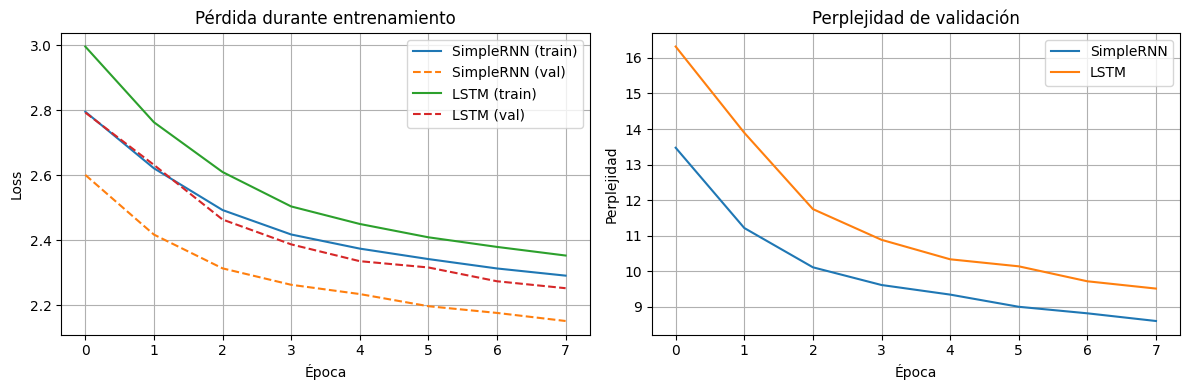

 MEJOR MODELO: SimpleRNN
Perplejidad: 8.60
\COMPARACIÓN DE MODELOS
SimpleRNN: Perplejidad = 8.60
LSTM: Perplejidad = 9.51


In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for nombre in historiales:
    plt.plot(historiales[nombre]['loss'], label=f'{nombre} (train)')
    plt.plot(historiales[nombre]['val_loss'], label=f'{nombre} (val)', linestyle='--')
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for nombre in historiales:
    perplexities = [np.exp(loss) for loss in historiales[nombre]['val_loss']]
    plt.plot(perplexities, label=nombre)
plt.title('Perplejidad de validación')
plt.xlabel('Época')
plt.ylabel('Perplejidad')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

mejor_modelo_nombre = min(resultados.keys(), key=lambda x: resultados[x]['final_perplexity'])
mejor_modelo = resultados[mejor_modelo_nombre]['model']

print(f" MEJOR MODELO: {mejor_modelo_nombre}")
print(f"Perplejidad: {resultados[mejor_modelo_nombre]['final_perplexity']:.2f}")


print("\COMPARACIÓN DE MODELOS")
for nombre, resultado in resultados.items():
    print(f"{nombre}: Perplejidad = {resultado['final_perplexity']:.2f}")



Esta sección final implementa la generación de texto usando el mejor modelo (SimpleRNN) con cuatro textos semilla relacionados con el estilo de Eminem. El código aplica las tres estrategias de generación implementadas: búsqueda codiciosa, beam search y muestreo estocástico con diferentes temperaturas (0.7, 1.0, 1.2). Los resultados evidencian problemas persistentes en el modelo: tanto la búsqueda codiciosa como beam search caen en bucles repetitivos generando secuencias como "the the the" o "ther the ther". El muestreo estocástico muestra mejores resultados con mayor variabilidad, especialmente a temperaturas más altas, generando pseudopalabras que mantienen cierta estructura fonética del inglés pero sin coherencia semántica. A temperatura 0.7 se observan fragmentos más reconocibles como "you", "the", "love", mientras que temperaturas más altas (1.2) producen texto más experimental pero menos legible. Los resultados sugieren que el modelo ha aprendido algunos patrones básicos del lenguaje a nivel de caracteres pero no logra generar texto coherente, posiblemente debido al tamaño limitado del corpus, la longitud de secuencia insuficiente, o la necesidad de arquitecturas más sofisticadas para este tipo de tarea generativa.

In [16]:
start_texts = ["rap", "slim shady", "mom", "lose"]

for start_text in start_texts:
    print(f"--- Texto semilla: '{start_text}' ---")

    # Búsqueda codiciosa corregida
    print("Búsqueda codiciosa:")
    try:
        greedy_result = greedy_search(mejor_modelo, start_text, 120)
        print(greedy_result)
    except Exception as e:
        print(f"Error en greedy search: {e}")

    # Beam search corregido
    print("\nBeam search:")
    try:
        beam_result = beam_search(mejor_modelo, start_text, beam_width=3, num_generate=80)
        print(beam_result)
    except Exception as e:
        print(f"Error en beam search: {e}")

    # Muestreo estocástico corregido
    temperaturas = [0.7, 1.0, 1.2]
    print("\nMuestreo estocástico:")

    for temp in temperaturas:
        print(f"\nTemperatura {temp}:")
        try:
            stoch_result = stochastic_sampling(mejor_modelo, start_text, temperature=temp, num_generate=120)
            print(stoch_result)
        except Exception as e:
            print(f"Error con temperatura {temp}: {e}")

--- Texto semilla: 'rap' ---
Búsqueda codiciosa:
rap the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Beam search:
rap ther the ther the ther the ther the ther the ther the ther the ther the ther th

Muestreo estocástico:

Temperatura 0.7:
rape fule omat not cari a do ind af thit soon jughe lirs ing ning so an a byemet tatt inl whe ouns in wher a gum een cas si

Temperatura 1.0:
rapeve asey tho fownd you sey wunaet yus tann bat bei isp whiser i sait rlake it syalind bory uas hee no tald eve whose cow

Temperatura 1.2:
rapg ic mani ma thok hnxpom my covy u coutes wapkebead luet the is meeengcy ur thpajus biaegrst loul grat boveo yhasiou eve
--- Texto semilla: 'slim shady' ---
Búsqueda codiciosa:
slim shady the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Beam search:
slim shady the ther the ther the ther the ther the ther the ther the ther the t